In [1]:
# Import the required packages
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast, os
import bambi as bmb
import pymc as pm
import arviz as az
import scipy.stats as stat
from collections import Counter
import itertools, ast

In [2]:
#Set up plotting themes
sns.set_context('poster')
sns.set_style('darkgrid')

# Function to clean the data files

#### For each data file this function does the following:
1. Drops irrelevant columns
2. Computes accuracies (accurate if all correct keys pressed on the first try)
3. Label Node types: Boundary vs non boundary
4. Label transition types: Cross cluster or within cluster
4. Label other relevant conditions like walk length, number of keypresses, etc. 

In [3]:
def clean_data(filename, which_data = 'mem data'):
    # print(filename)
    # Handle errors. If there is an error, go to 'except' and return nothing.
    try:
        data = pd.read_csv('data/' + filename)

        # Drop instruction rows by dropping rows with missing data in column: 'blocks.thisRepN'
        data = data.dropna(subset=['trials.thisRepN']).reset_index(drop=True)

        #If data file is incomplete, raise an error. 
        #Label conditions based on participant number as was designed in the experiment
        if data['participant'][0]%2 == 0:
            data['condition'] = 'structured'
        else:
            data['condition'] = 'unstructured'

        # data['trial'] = np.arange(len(data))
        
        
    except:
        return None
    #filtering exposure data, removing rows with no path id
    exposure  = data.loc[data['path id'].notna(), ['trials.thisN', 'path id', 'stim chosen', 'key_resp.rt', 'key_resp.corr', 'condition']].reset_index(drop=True)
    exposure.rename(columns = {'trials.thisN': 'trials', 'key_resp.corr':'accuracy', 'key_resp.rt':'rt'}, inplace = True)
    #New column to define a block    
    exposure['block'] = np.repeat(np.arange(3), 250)
    #node types
    exposure['node type'] = 'nonboundary'
    exposure.loc[(exposure['path id'].isin([0, 4, 5, 9, 10, 14])), 'node type'] = 'boundary'
    exposure['participant'] = data['participant'][0]

    #extracting actual boundary vs non boundary stimuli files that were shown. 
    boundary_stim = exposure.loc[exposure['node type'] == 'boundary', 'stim chosen'].unique()
    nonboundary_stim = exposure.loc[exposure['node type'] == 'nonboundary', 'stim chosen'].unique()
    
    #Filtering memory data, removing rows with nothing in the 'old or new' column
    memory = data.loc[data['old or new'].notna(), ['mem_test_key_resp.rt', 'old or new', 'old or new accuracy', 'test item', 'condition']].reset_index(drop=True)
    memory['trials'] = np.arange(90)
    memory['block'] = np.repeat(np.arange(3), 30)
    #Node types
    memory['node type'] = 'new'
    #Testing whether if each test item is in the boundary stim list
    memory.loc[memory['test item'].isin(boundary_stim), 'node type'] = 'boundary'
    memory.loc[memory['test item'].isin(nonboundary_stim), 'node type'] = 'nonboundary'
    memory.rename(columns={'mem_test_key_resp.rt':'rt', 'old or new accuracy':'accuracy'}, inplace=True)
    #Translating string rts to numerical rts
    memory['rt'] = [ast.literal_eval(i)[0] for i in memory['rt']]
    memory['participant'] = data['participant'][0]

    #Return the dataframe with relevant columns
    if which_data == 'mem data':
        return memory 
    else:
        return exposure
        # return filtered_data.loc[filtered_data['old or new'].isna()].reset_index(drop=True)
        


# Read the data files

In [4]:
#reads in all the NAMES of the data files from the 'data' folder. 
data_files = []
for f in os.listdir('data/'):
    if (f.startswith('24') & f.endswith('csv')):
        data_files.append(f)

# Cleaning the data files into a single large dataframe

1. Label Trials, conditions, etc. 
2. Combine relevant columns of extracted data files 
3. Specify outliers and remove them


In [5]:
df_clean_exposure = pd.concat([clean_data(f, which_data='non mem data') for f in data_files]).reset_index(drop = True)
df_clean_memory = pd.concat([clean_data(f) for f in data_files]).reset_index(drop = True)

# df_clean['reset'] = 'False'
# df_clean.loc[df_clean['trial'].values%(df_clean['walk_length'].values+1) == 0, 'reset'] = 'True'



# df_clean_rt_outlier = df_clean[np.abs(stat.zscore(df_clean['rt'], nan_policy='omit')) < 3]
# df_clean_rt_outlier['node_transition_type'] = df_clean_rt_outlier['node_type'] + ' ' + df_clean_rt_outlier['transition_type']

# df_clean_participant = df_clean_rt_outlier.groupby(['participant', 'graph identity', 'condition', 'test no']).mean(numeric_only = True).reset_index()

# # df_clean_rt_outlier['walk_length'] = df_clean_rt_outlier.walk_length.astype('str')
# # df_clean_rt_outlier['num_keypress'] = df_clean_rt_outlier['num_keypress'].astype(str)

# df_clean_participant

In [41]:
recency_cutoff = 75
df_clean_memory['recent'] = 'No'
for participant in df_clean_memory.participant.unique():
    for block in range(3):
        recent_stim = df_clean_exposure.loc[((df_clean_exposure['block'] == block) & (df_clean_exposure['participant'] == participant)), 'stim chosen'].values[-recency_cutoff:]
        df_clean_memory.loc[((df_clean_memory.participant == participant) & (df_clean_memory['test item'].isin(recent_stim)) & (df_clean_memory['block'] == block)), 'recent'] = 'Yes' 

In [42]:
len(df_clean_memory.loc[((df_clean_memory['recent'] == 'No') & (df_clean_memory['condition'] == 'structured') & (df_clean_memory['node type'] != 'new') & (df_clean_memory['block'] == 2))])

28

# Plot RTs


In [43]:
# df_clean_rt_outlier

# Plot Accuracies
1. Rotation
2. REcency


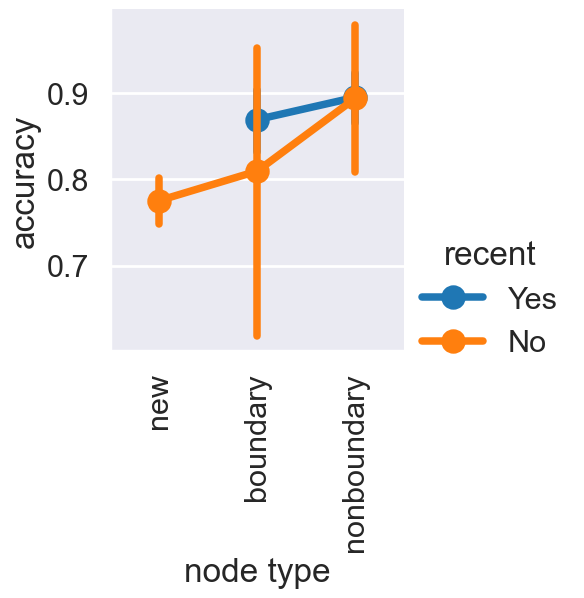

In [44]:
g = sns.catplot(x = 'node type', y = 'accuracy',  hue = 'recent',
           data = df_clean_memory, kind = 'point', margin_titles=True, order = ['new', 'boundary', 'nonboundary'])#, row = 'condition')
g.set_xticklabels(['new', 'boundary', 'nonboundary'], rotation=90)

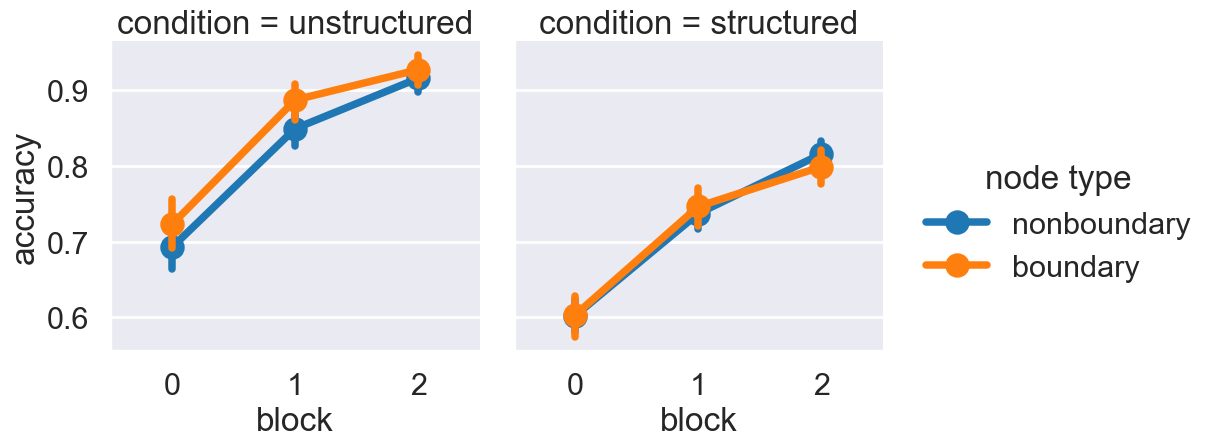

In [77]:
g = sns.catplot(x = 'block', y = 'accuracy',  col = 'condition',
           data = df_clean_exposure, kind = 'point', margin_titles=True, hue = 'node type')
# g.set_xticklabels(rotation=90)

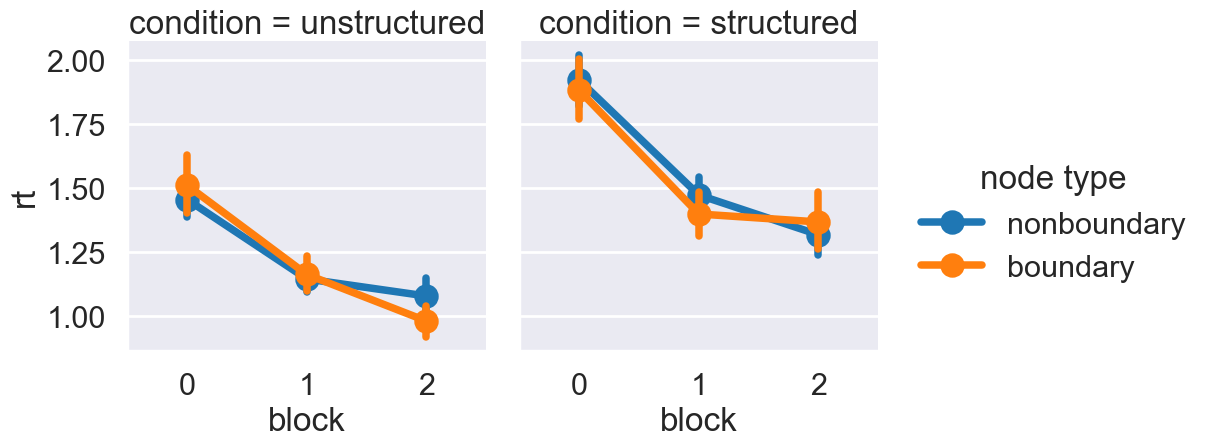

In [80]:
g = sns.catplot(x = 'block', y = 'rt',  col = 'condition',
           data = df_clean_exposure, kind = 'point', margin_titles=True, hue = 'node type')
# g.set_xticklabels(rotation=90)

In [46]:
df_clean_exposure['phase'] = 'exposure'
df_clean_memory['phase'] = 'memory'

In [47]:
concat_df = pd.concat([df_clean_exposure[['rt', 'accuracy', 'condition', 'block', 'node type', 'participant', 'phase']],
df_clean_memory[['rt', 'accuracy', 'condition', 'block', 'node type', 'participant', 'phase']]]).reset_index(drop=True)



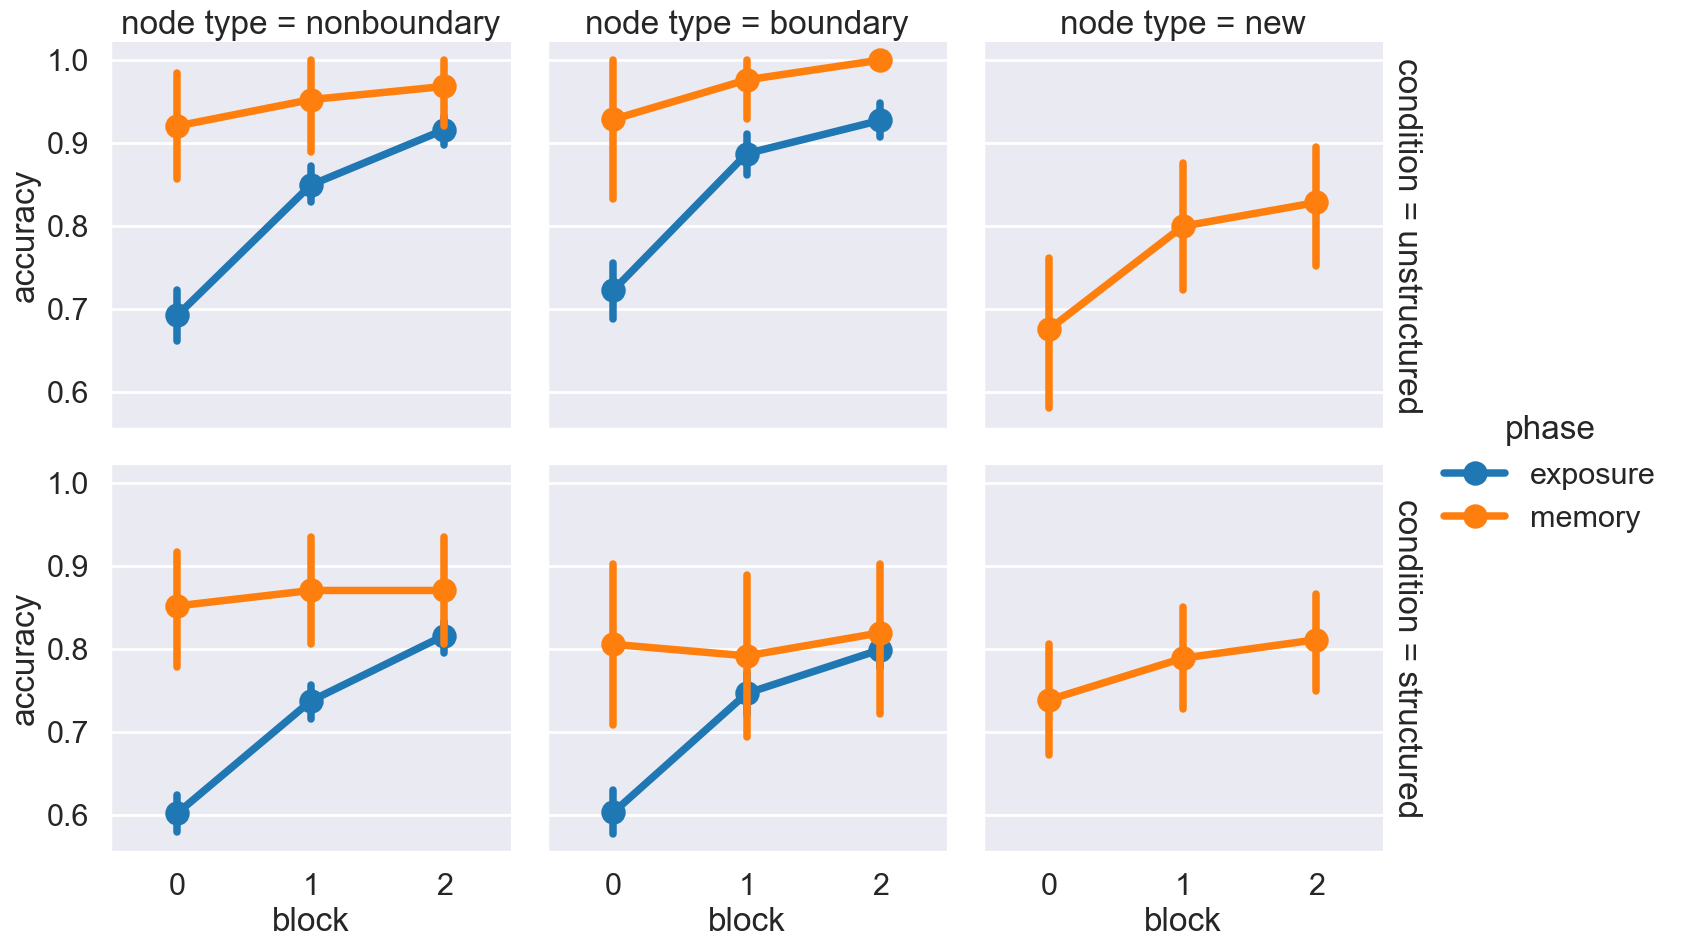

In [48]:
g = sns.catplot(x = 'block', y = 'accuracy',  col = 'node type',
           data = concat_df, kind = 'point', margin_titles=True, hue = 'phase', row = 'condition')

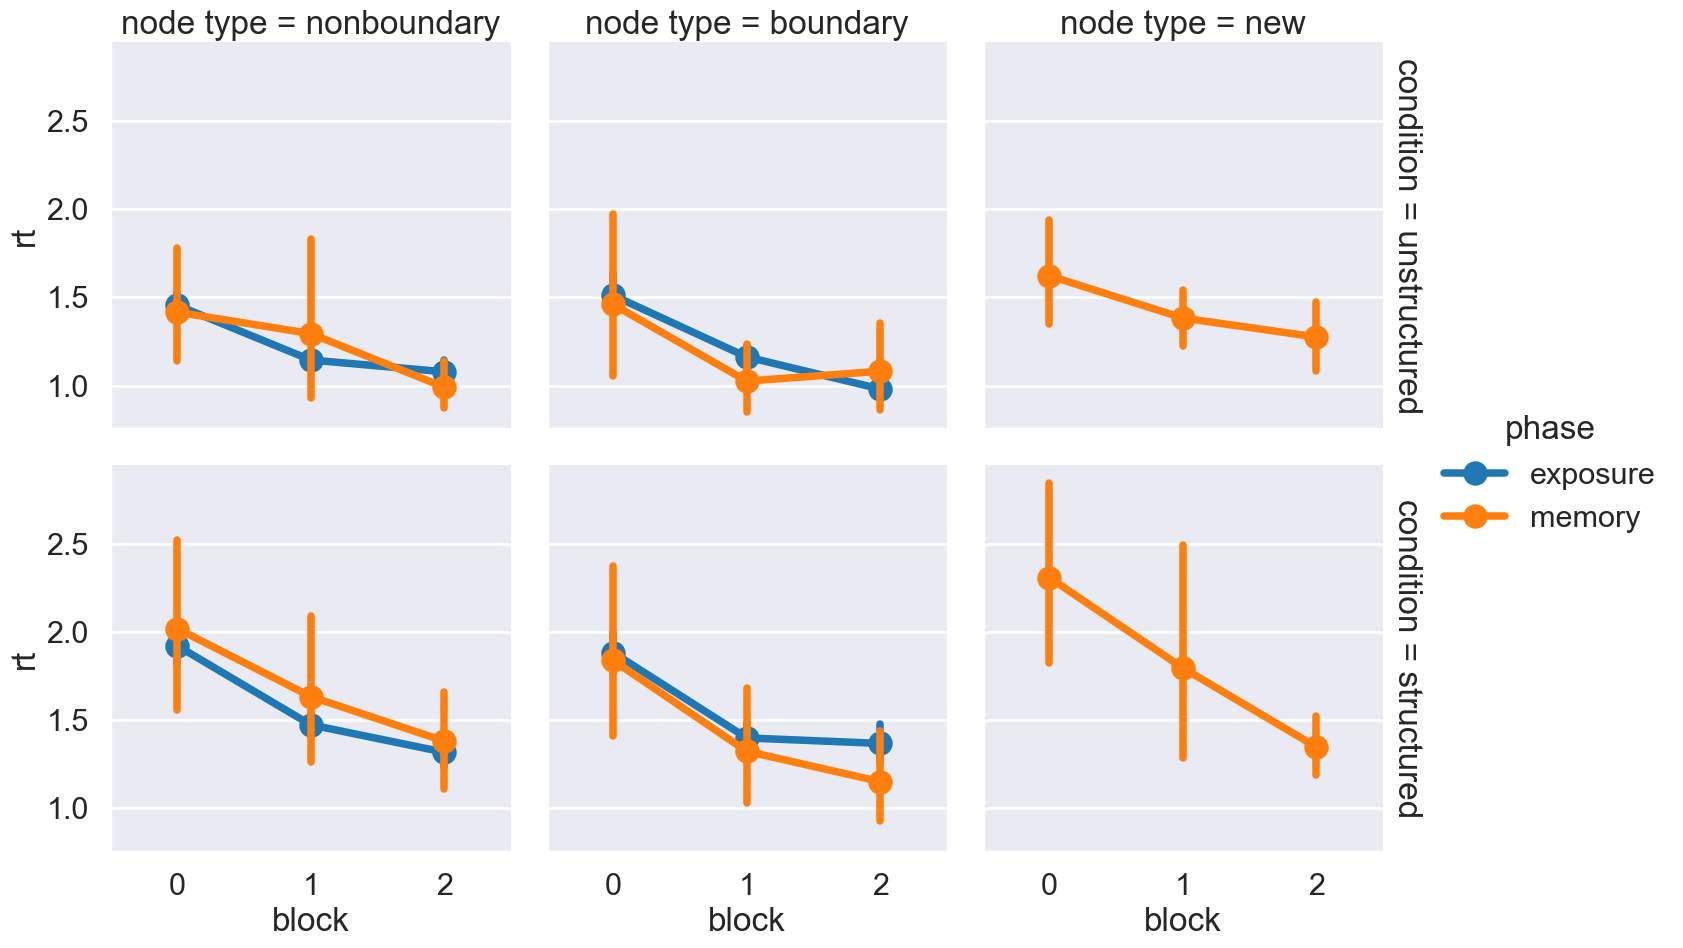

In [49]:
g = sns.catplot(x = 'block', y = 'rt',  col = 'node type',
           data = concat_df, kind = 'point', margin_titles=True, hue = 'phase', row = 'condition')

In [54]:
df_clean = pd.concat([clean_data(f, 'learning') for f in data_files]).reset_index(drop = True)
# df_clean['reset'] = 'False'
# df_clean.loc[df_clean['trial'].values%(df_clean['walk_length'].values+1) == 0, 'reset'] = 'True'



# df_clean_rt_outlier = df_clean[np.abs(stat.zscore(df_clean['rt'], nan_policy='omit')) < 3]
# df_clean_rt_outlier['node_transition_type'] = df_clean_rt_outlier['node_type'] + ' ' + df_clean_rt_outlier['transition_type']

# df_clean_participant = df_clean_rt_outlier.groupby(['participant', 'graph identity', 'condition', 'test no']).mean(numeric_only = True).reset_index()

# # df_clean_rt_outlier['walk_length'] = df_clean_rt_outlier.walk_length.astype('str')
# # df_clean_rt_outlier['num_keypress'] = df_clean_rt_outlier['num_keypress'].astype(str)

# df_clean_participant

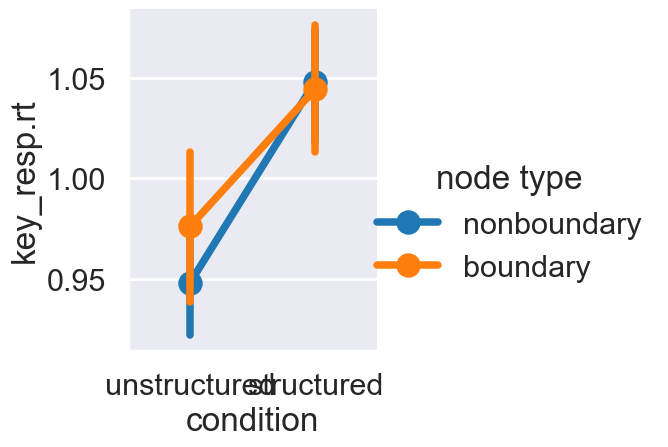